I ran this notebook on a Google Collab with a Tesla T4 GPU and got about 18k tokens/second while training.
Maybe will optimise more in the future!
Lets first play with some stuff.

In [ ]:
from transformers import GPT2LMHeadModel

In [ ]:
play_model = GPT2LMHeadModel.from_pretrained("gpt2")
state_dict = play_model.state_dict()

for key, value in state_dict.items():
    print(f"{key}: {value.shape}")

transformer.wte.weight: torch.Size([50257, 768])
transformer.wpe.weight: torch.Size([1024, 768])
transformer.h.0.ln_1.weight: torch.Size([768])
transformer.h.0.ln_1.bias: torch.Size([768])
transformer.h.0.attn.c_attn.weight: torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias: torch.Size([2304])
transformer.h.0.attn.c_proj.weight: torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias: torch.Size([768])
transformer.h.0.ln_2.weight: torch.Size([768])
transformer.h.0.ln_2.bias: torch.Size([768])
transformer.h.0.mlp.c_fc.weight: torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias: torch.Size([3072])
transformer.h.0.mlp.c_proj.weight: torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias: torch.Size([768])
transformer.h.1.ln_1.weight: torch.Size([768])
transformer.h.1.ln_1.bias: torch.Size([768])
transformer.h.1.attn.c_attn.weight: torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias: torch.Size([2304])
transformer.h.1.attn.c_proj.weight: torch.Size([768, 768])
transformer.h.

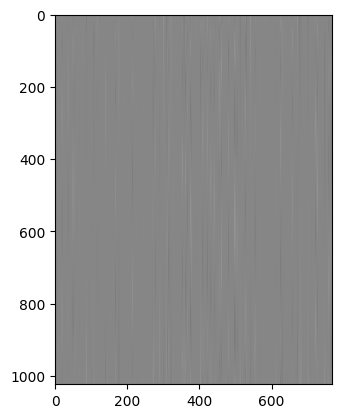

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(state_dict['transformer.wpe.weight'].detach().cpu().numpy(), cmap='gray')

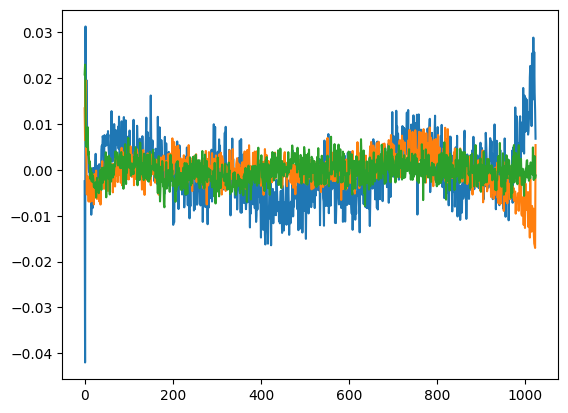

In [4]:
plt.plot(state_dict['transformer.wpe.weight'][:,10])
plt.plot(state_dict['transformer.wpe.weight'][:,20])
plt.plot(state_dict['transformer.wpe.weight'][:,30])

In [ ]:
from transformers import pipeline, set_seed
play_generator = pipeline('text-generation', model='gpt2')
set_seed(69)
play_generator("Hello, my dog is", max_length=30, num_return_sequences=5)

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=256) and `max_length`(=30) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


[{'generated_text': 'Hello, my dog is my best friend. We are both very playful and our friendship is always growing. And my dog is always happy and healthy. I love her constantly and always look forward to seeing her again, she will be my future dog. I am so grateful for the amazing support.\n\nI love doing everything possible and that is why I love making this blog and sharing with you!'},
 {'generated_text': "Hello, my dog is a very beautiful pet. I'm so happy to have him here as he's been a huge part of the family since he was just a little girl. He's always been my go-to companion and I love his love of playing with his little one. I'm so happy to have him back.\n\nTina, do you have any questions for my dear fellow dog?\n\nThe family is very friendly and helpful. They are always helpful and helpful to our customers."},
 {'generated_text': 'Hello, my dog is very excited to be here today. I wish you all the best for the future of your dogs and for the future of your family! I have re

Now lets get into the real stuff, the training of an actual model
First off, lets import the things we need

In [ ]:
from dataclasses import dataclass
import inspect
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import sys

Good, now lets declare some classes, first off the config of our model
This is a dataclass that holds some variables, such as our vocab_size, block_size, and other hyperparameters.

In [ ]:
# configured for the GPT2 124M model
@dataclass
class Config:
    block_size: int = 1024
    vocabulary_size: int = 50257
    n_layer: int = 12
    n_head: int = 12
    n_embd: int = 768

Now lets declare our Causal Self-Attention layer.
This layer will be responsible for the self attention mechanism in our model.

In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0, "n_embd must be divisible by n_head"

        self.c_attn = nn.Linear(config.n_embd, config.n_embd * 3)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)

        self.c_proj.SCALE_INIT = 1

        self.n_head = config.n_head
        self.n_embd = config.n_embd

        # causal mask, or "bias" xD
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        batch_size, seq_length, nr_channels = x.size()

        # compute query, key, value 
        qkv = self.c_attn(x)
        q,k,v = qkv.split(self.n_embd, dim=2)
        k = k.view(batch_size, seq_length, self.n_head, nr_channels // self.n_head).transpose(1, 2)
        q = q.view(batch_size, seq_length, self.n_head, nr_channels // self.n_head).transpose(1, 2)
        v = v.view(batch_size, seq_length, self.n_head, nr_channels // self.n_head).transpose(1, 2)

        # attention = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # attention = attention.masked_fill(self.bias[:,:,:seq_length,:seq_length] == 0, float('-inf'))
        # attention = F.softmax(attention, dim=-1)
        # # attention dropout
        # y = attention @ v

        # flash attention (replaces the 4 lines above)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=True)
        
        y = y.transpose(1, 2).contiguous().view(batch_size, seq_length, nr_channels)

        # output projection
        return self.c_proj(y)

And our Multi-Layered Perceptron (MLP) class.
This class will be responsible for the feedforward layers in our model.

In [ ]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.c_fc = nn.Linear(config.n_embd, 4 * config.n_embd)
        self.gelu = nn.GELU(approximate='tanh') # GPT2 used an approx. for GELU, more here https://docs.pytorch.org/docs/stable/generated/torch.nn.GELU.html
        self.c_proj = nn.Linear(4 * config.n_embd, config.n_embd)
        self.c_proj.SCALE_INIT = 1

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

Lets combine our SelfAttention and MLP classes into a single Block class.
This class will represent a single block of the Transformer architecture.

In [ ]:
class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = SelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = MLP(config)  

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

Now the fun begins, lets make our GPT class, defining our model.

In [ ]:
class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocabulary_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocabulary_size, bias=False)

        self.transformer.wte.weight = self.lm_head.weight # tie weights
        self.apply(self._init_weights)  # initialize weights

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            torch.nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        batch_size, seq_length = idx.size()
        assert seq_length <= self.config.block_size, "sequence length exceeds block size"

        # forward the token and pos embeddings
        position = torch.arange(0, seq_length, dtype=torch.long, device=idx.device)
        position_embeddings = self.transformer.wpe(position)
        token_embeddings = self.transformer.wte(idx)
        x = token_embeddings + position_embeddings

        # forward through the blocks
        for block in self.transformer.h:
            x = block(x)

        # forward thru the final layer norm & classifier
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)
        loss = None
        if targets is not None:
            # compute the loss
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1))
        return logits, loss

    @classmethod
    def from_pretrained(cls, model_name_or_path):
        # load a pretrained model from huggingface
        assert model_name_or_path in ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'], "model not supported"

        from transformers import GPT2LMHeadModel
        print(f"loading pretrained model {model_name_or_path} from huggingface...")

        configs = {
            'gpt2': dict(n_embd=768, n_layer=12, n_head=12), # 124M
            'gpt2-medium': dict(n_embd=1024, n_layer=24, n_head=16), # 350M
            'gpt2-large': dict(n_embd=1280, n_layer=36, n_head=20), # 774M
            'gpt2-xl': dict(n_embd=1600, n_layer=48, n_head=25) # 1558M
        }[model_name_or_path]

        configs['vocabulary_size'] = 50257 # these are the same for all models
        configs['block_size'] = 1024

        config = Config(**configs)
        model = GPT(config)

        state_dict = model.state_dict()
        state_dict_keys = state_dict.keys()
        state_dict_keys = [k for k in state_dict_keys if not k.endswith('.attn.bias')] # discard attention bias (mask)

        model_hf = GPT2LMHeadModel.from_pretrained(model_name_or_path)
        state_dict_hf = model_hf.state_dict()

        state_dict_keys_hf = state_dict_hf.keys()
        state_dict_keys_hf = [k for k in state_dict_keys_hf if not k.endswith('.attn.masked_bias')] # discard masked bias
        state_dict_keys_hf = [k for k in state_dict_keys_hf if not k.endswith('.attn.bias')] # same


        assert len(state_dict_keys) == len(state_dict_keys_hf), "state dict keys mismatch"

        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']

        for key in state_dict_keys_hf:
            if any(key.endswith(w) for w in transposed):
                assert state_dict[key].shape == state_dict_hf[key].shape[::-1], f"shape mismatch for {key}"
                with torch.no_grad():
                    state_dict[key].copy_(state_dict_hf[key].t())

            else:
                assert state_dict[key].shape == state_dict_hf[key].shape, f"shape mismatch for {key}"
                with torch.no_grad():
                    state_dict[key].copy_(state_dict_hf[key])

        return model
    
    def configure_optimizers(self, weight_decay=0.1, learn_rate=6e-4, device='cpu'):
        param_dict = {pn: p for pn, p in self.named_parameters() if p.requires_grad}
        decay_params = [p for n, p in param_dict.items() if p.dim() >= 2]
        no_decay_params = [p for n, p in param_dict.items() if p.dim() < 2]

        groups = [
            {'params': decay_params, 'weight_decay': weight_decay},
            {'params': no_decay_params, 'weight_decay': 0.0},
        ]

        sig = inspect.signature(torch.optim.AdamW).parameters
        adamw_kwargs = dict(lr=learn_rate, betas=(0.9, 0.95), eps=1e-8)
        if 'weight_decay' not in adamw_kwargs:
            pass
        if ('fused' in sig) and (device == 'cuda'):
            adamw_kwargs['fused'] = True  # only pass when available

        print(f"using {'fused' if adamw_kwargs.get('fused', False) else 'non-fused'} AdamW")
        return torch.optim.AdamW(groups, **adamw_kwargs)

We will need some helper classes / functions to make our model training easier, so lets define those too.
Also, change these variables if you want to change how the training is done.

In [ ]:
nr_return_sequences = 5
max_length = 30
max_learning_rate = 6e-4
min_learning_rate = max_learning_rate / 10 # 10% decrease of the learning rate
warmup_steps = 10
max_steps = 50

batch_size = 2**19
micro_batch_size = 1
seq_length = 1024

seed = 69

In [ ]:
import tiktoken
class DataLoader:
    def __init__(self, batch_size, seq_length, filepath="input.txt"):
        self.batch_size = batch_size
        self.seq_length = seq_length

        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read()

        self.enc = tiktoken.get_encoding("gpt2")
        ids = self.enc.encode(text)
        self.tokens = torch.tensor(ids, dtype=torch.long)
        self.num_tokens = len(self.tokens)
        print(f"loaded {self.num_tokens} tokens from {filepath}")

        # rough idea of how many steps make an epoch
        self.steps_per_epoch = max(1, self.num_tokens // (self.batch_size * self.seq_length))
        print(f"~{self.steps_per_epoch} steps per epoch (rough)")

    def next_batch(self):
        # sample independent random starts for each item in batch
        starts = torch.randint(
            low=0,
            high=self.num_tokens - self.seq_length - 1,
            size=(self.batch_size,),
        )
        x = torch.stack([self.tokens[s:s+self.seq_length] for s in starts])
        y = torch.stack([self.tokens[s+1:s+self.seq_length+1] for s in starts])
        return x, y
    
@torch.no_grad()
def eval_loss(model, loader, iters=50, device='cpu'):
    model.eval()
    losses = []
    for _ in range(iters):
        x, y = loader.next_batch()
        x, y = x.to(device), y.to(device)
        _, loss = model(x, y)
        losses.append(loss.item())
    model.train()
    return sum(losses) / len(losses)

def save_ckpt(path, model, optimizer):
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'config': model.config.__dict__,
    }, path)


# can also use https://docs.pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html
# but where is the fun in that?
def get_learning_rate(iteration):
    if iteration < warmup_steps:
        return max_learning_rate * (iteration + 1) / warmup_steps
    
    if iteration > max_steps:
        return min_learning_rate
    
    cosine_decay_ratio = (iteration - warmup_steps) / (max_steps - warmup_steps)
    assert 0 <= cosine_decay_ratio <= 1
    coefficient = 0.5 * (1 + math.cos(cosine_decay_ratio * math.pi))
    return min_learning_rate + (max_learning_rate - min_learning_rate) * coefficient

@torch.no_grad()
def generate_text(model, prompt, max_new_tokens=100, temperature=1.0, top_p=0.9, device='cpu'):
    enc = tiktoken.get_encoding("gpt2")
    model.eval()
    idx = torch.tensor([enc.encode(prompt)], dtype=torch.long, device=device)

    for _ in range(max_new_tokens):
        # crop to block_size to avoid pos-embed overflow
        idx_cond = idx[:, -model.config.block_size:]
        logits, _ = model(idx_cond)
        logits = logits[:, -1, :] / max(1e-9, temperature)
        probs = torch.softmax(logits, dim=-1)

        sorted_probs, sorted_idx = torch.sort(probs, descending=True)
        cum = torch.cumsum(sorted_probs, dim=-1)
        cutoff = cum > top_p
        sorted_probs[cutoff] = 0
        sorted_probs.div_(sorted_probs.sum(dim=-1, keepdim=True))

        next_id = torch.gather(sorted_idx, -1, torch.multinomial(sorted_probs, num_samples=1))
        idx = torch.cat([idx, next_id], dim=1)

    return enc.decode(idx[0].tolist())
    

Finally, we are (somewhat) ready for our training loop!
We just need to make some preparations first.

In [ ]:
if torch.cuda.is_available():
    device = "cuda" # nvidia 
elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = "mps" # apple
else:
    device = "cpu" # cpu fallback
print(f"using device: {device}")


import random, numpy as np
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)


assert batch_size % (micro_batch_size * seq_length) == 0, "batch size must be divisible by micro batch size times seq length"
gradient_accumulation_steps = batch_size // (micro_batch_size * seq_length)
print(f"gradient accumulation steps: {gradient_accumulation_steps}")


train_loader = DataLoader(batch_size=micro_batch_size, seq_length=seq_length, filepath="input.txt")

torch.set_float32_matmul_precision('high') # use TF32 (or try to)

model = GPT(Config(vocabulary_size=50257))  # can also override this to 50304 
                                            # (has a lot of powers of 2, easy for matmul to process)
                                            # keep in mind that you need to change the tokenizer too.

model.to(device)
#model = torch.compile(model) # this might make it run faster

#optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, betas=(0.9, 0.95), weight_decay=1e-2, eps=1e-8)
optimizer = model.configure_optimizers(weight_decay = 0.1, learn_rate = 6e-4, device=device)
use_amp = (device == 'cuda')
scaler = torch.amp.GradScaler(device=device, enabled=use_amp)

Now lets define the loop!!

In [ ]:
for i in range(max_steps):
    t0 = time.time()
    optimizer.zero_grad(set_to_none=True)
    accumulated_loss = 0.0

    for _ in range(gradient_accumulation_steps):
        x, y = train_loader.next_batch()
        x, y = x.to(device), y.to(device)

        with torch.amp.autocast(device_type=device,enabled=use_amp):
            _, loss = model(x, y)
            loss = loss / gradient_accumulation_steps
        accumulated_loss += float(loss.item())
        scaler.scale(loss).backward()

    scaler.unscale_(optimizer)
    norm = torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    lr = get_learning_rate(i)
    for g in optimizer.param_groups:
        g['lr'] = lr
    scaler.step(optimizer)
    scaler.update()

    if device == 'cuda':
        torch.cuda.synchronize()
    elif device == 'mps':
        torch.mps.synchronize()

    dt = (time.time() - t0)
    tps = (micro_batch_size * seq_length * gradient_accumulation_steps) / dt
    print(f"step {i:4d} | lr {lr:.4e} | loss {accumulated_loss:.6f} | time {dt*1000:.1f}ms | grad_norm {norm:.3f} | tok/s {tps:.1f}")

    if (i+1) % 50 == 0:
        val = eval_loss(model, train_loader, iters=50, device=device)  # quick&dirty on same data file
        print(f"[eval] val_loss {val:.4f}")
        save_ckpt(f"ckpt_step_{i+1}.pt", model, optimizer)


Everything is ready to generate some stuff now!

In [ ]:

print(generate_text(model, "Once upon a time", max_new_tokens=60, temperature=0.9, top_p=0.95, device=device))
